<a href="https://colab.research.google.com/github/Agnes-FD/Agnes-FD/blob/main/Model_CNN47.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
cd '/content/drive/MyDrive/data'

/content/drive/MyDrive/data


In [32]:
ls

with_mask/  without_mask/


In [33]:
import os
path = '/content/drive/MyDrive/data'
# Membuat Label pada gambar berdasarkan klasifikasi
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(path):
  for name in files:
    full_path.append(os.path.join(path, name))
    tag.append(path.split('/')[-1])
    file_name.append(name)

In [34]:
# Membuat dataframe berdasarkan hasil klasifikasi data yang sudah diberi label
import pandas as pd

df = pd.DataFrame({"path":full_path, "file_name": file_name, "tag":tag})
df.groupby(['tag']).size()

tag
with_mask       3725
without_mask    3858
dtype: int64

In [35]:
# cek data yang sudah diberi label
df

,path,file_name,tag
0,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3409.jpg,with_mask
1,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3435.jpg,with_mask
2,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3402.jpg,with_mask
3,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3494.jpg,with_mask
4,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3499.jpg,with_mask
...,...,...,...
7578,/content/drive/MyDrive/data/without_mask/witho...,without_mask_2074.jpg,without_mask
7579,/content/drive/MyDrive/data/without_mask/witho...,without_mask_2419.jpg,without_mask
7580,/content/drive/MyDrive/data/without_mask/witho...,without_mask_127.jpg,without_mask
7581,/content/drive/MyDrive/data/without_mask/witho...,without_mask_1333 (1).jpg,without_mask


In [36]:
# Membagi dataset menjadi dua bagian (train dan test)
from sklearn.model_selection import train_test_split

x = df['path']
y = df['tag']

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size= 0.20, random_state=300)
x_test, x_val, y_test, y_val = train_test_split(
    x_test,y_test, test_size=0.5, random_state=100
)

In [37]:
# menyatukan kedalam masing-masing dataframe
df_test = pd.DataFrame({
    'path' : x_test,
    'tag' : y_test,
    'set' : 'test'
})

df_train = pd.DataFrame({
    'path' : x_train,
    'tag' : y_train,
    'set' : 'train'
})
df_val = pd.DataFrame({
    'path' : x_val,
    'tag' : y_val,
    'set' : 'validation'
})

In [38]:
print('train size', len(df_train))
print('test size', len(df_test))
print('validation size', len(df_val))

train size 6066
test size 758
validation size 759


In [39]:
# melihat masing-masing dataset apakah sudah sesuai atau belum
df_all = df_train.append([df_test, df_val]).reset_index(drop=1)

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(4)


set         tag         
test        with_mask        363
            without_mask     395
train       with_mask       3001
            without_mask    3065
validation  with_mask        361
            without_mask     398
dtype: int64 




,path,tag,set
147,/content/drive/MyDrive/data/without_mask/witho...,without_mask,train
6951,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,validation
6711,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,test
4055,/content/drive/MyDrive/data/without_mask/witho...,without_mask,train


In [40]:
# Memindahkan dataset
import shutil
from tqdm.notebook import tqdm as tq
datasource_path = '/content/drive/MyDrive/data'
dataset_path = '/content/drive/MyDrive/dataset'

In [41]:
for index, row in tq(df_all.iterrows()):
  file_path = row['path']

  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['tag'], row['image'].split('.')[0])

  if os.path.exists(os.path.join(dataset_path, row['set'], row['tag'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['tag']))
  
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['tag'], destination_file_name)

  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

In [42]:
# Define Directory
base_dir = '/content/drive/MyDrive/dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'validation')

In [43]:
#train test split
from sklearn.model_selection import train_test_split
train_without_mask_dir = os.path.join(train_dir, 'without_mask')
train_with_mask_dir = os.path.join(train_dir, 'with_mask')
test_without_mask_dir = os.path.join(test_dir, 'without_mask')
test_with_mask_dir = os.path.join(test_dir, 'with_mask')
val_without_mask_dir = os.path.join(val_dir, 'without_mask')
val_with_mask_dir = os.path.join(val_dir, 'with_mask')

In [44]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.4.1


In [45]:
#Image Augmentation
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'binary'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'binary'
)
val_generator = datagen.flow_from_directory(
    test_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'binary'
)

Found 7256 images belonging to 2 classes.
Found 2107 images belonging to 2 classes.
Found 2107 images belonging to 2 classes.


In [81]:
# Membuat Model CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_cnn = Sequential()

model_cnn.add(Conv2D(32,(3,3), activation= 'relu', padding= 'same', name='conv_1', input_shape=(256,256,3)))
model_cnn.add(MaxPooling2D((2,2), name='maxpool_1'))
model_cnn.add(Conv2D(64,(3,3),activation='relu', padding='same', name='conv_2'))
model_cnn.add(MaxPooling2D((2,2), name='maxpool_2'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Conv2D(128,(3,3),activation='relu',padding='same', name='conv_3'))
model_cnn.add(MaxPooling2D((2,2), name='maxpool_3'))
model_cnn.add(Conv2D(256,(3,3),activation='relu',padding='same' ,name='conv_4'))
model_cnn.add(MaxPooling2D((2,2), name='maxpool_4'))

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(128, activation='relu', name= 'dense_1'))
model_cnn.add(Dense(16, activation='relu', name= 'dense_2'))
model_cnn.add(Dense(1 , activation='sigmoid', name= 'output'))
model_cnn.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 128, 128, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 128, 128, 64)      18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 64, 64, 128)       73856     
_________________________________________________________________
maxpool_3 (MaxPooling2D)     (None, 32, 32, 128)     

In [82]:
print('Compiling Model.......')
model_cnn.compile (optimizer='Adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

Compiling Model.......


In [83]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print('Akurasi mencapai 97%, proses training dihentikan!')
      self.model.stop_training = True

callbacks = myCallback()

In [84]:
history_cnn = model_cnn.fit(
    train_generator,
    batch_size= 20,
    #steps_per_epoch = 20,
    epochs = 100,
    validation_data = test_generator,
    validation_steps = 20,
    callbacks = [callbacks]
)

Epoch 1/100
  5/227 [..............................] - ETA: 17:03 - loss: 1.1896 - accuracy: 0.4744

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


227/227 [==============================] - 1076s 5s/step - loss: 0.5443 - accuracy: 0.7204 - val_loss: 0.3046 - val_accuracy: 0.8953
Epoch 2/100
227/227 [==============================] - 1068s 5s/step - loss: 0.2919 - accuracy: 0.8817 - val_loss: 0.2600 - val_accuracy: 0.8844
Epoch 3/100
227/227 [==============================] - 1063s 5s/step - loss: 0.2404 - accuracy: 0.8976 - val_loss: 0.2129 - val_accuracy: 0.9344
Epoch 4/100
227/227 [==============================] - 1064s 5s/step - loss: 0.2130 - accuracy: 0.9133 - val_loss: 0.1775 - val_accuracy: 0.9359
Epoch 5/100
227/227 [==============================] - 1062s 5s/step - loss: 0.1881 - accuracy: 0.9300 - val_loss: 0.1657 - val_accuracy: 0.9422
Epoch 6/100
227/227 [==============================] - 1058s 5s/step - loss: 0.1726 - accuracy: 0.9334 - val_loss: 0.1460 - val_accuracy: 0.9547
Epoch 7/100
227/227 [==============================] - 1057s 5s/step - loss: 0.1589 - accuracy: 0.9410 - val_loss: 0.1828 - val_accuracy: 0.94

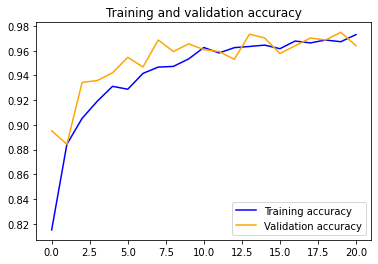

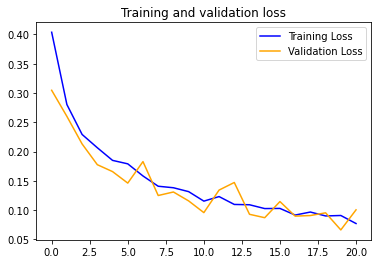

In [85]:
import matplotlib.pyplot as plt

acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [86]:
cd'/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [87]:
#save model
import os

In [88]:
MODEL_BASE_PATH = "Model"
PROJECT_NAME ="CNN"
SAVE_MODEL_NAME = "Model_CNN47.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model_cnn.save(save_model_path,include_optimizer=False)

Saving Model At Model/CNN/Model_CNN47.h5...
